<a href="https://colab.research.google.com/github/Abdelmounim1996/Distributed-Learning-of-Finite-Gaussian-Mixtures/blob/main/Expirimental_resultas_pMLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Abdelmounim1996/Distributed-Learning-of-Finite-Gaussian-Mixtures


Cloning into 'Distributed-Learning-of-Finite-Gaussian-Mixtures'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 106 (delta 38), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (106/106), 1.63 MiB | 7.54 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls '/content/Distributed-Learning-of-Finite-Gaussian-Mixtures/mylib/EM_pMLE.py'

/content/Distributed-Learning-of-Finite-Gaussian-Mixtures/mylib/EM_pMLE.py


In [5]:
!cat '/content/Distributed-Learning-of-Finite-Gaussian-Mixtures/mylib/EM_pMLE.py'

# library mathematic & statistic 
import numpy as np
import time 
from scipy.stats import multivariate_normal
from scipy import linalg
from numpy.linalg import multi_dot
#from sklearn.mixture.base import BaseMixture, _check_shape
from sklearn.utils import check_array, check_random_state
# library for machine learning
from sklearn.cluster import KMeans
np.seterr(divide='ignore', invalid='ignore')


class EM_pMLE:
    def __init__(self ,  n_components  ):
        self.n_components = n_components

    def fit(self , X  : int , n_iters = 500 , tol = 0.01 , init_params = None , reg_covar=1e-6 ):
        self.X            = X
        self.n_iters      = n_iters
        self.tol          = tol
        self.init_params  = init_params
        self.N , self.d   = self.X.shape
        self.converged    = False
        self.S_x          = np.cov(self.X , rowvar=False)
        self.Means   = None 
        self.Covars  = None 
        self.Weights = None
        self. reg_covar =  reg_covar
        

In [17]:
import sys
sys.path.append('/content/Distributed-Learning-of-Finite-Gaussian-Mixtures')

In [22]:
from mylib.EM_pMLE import EM_pMLE

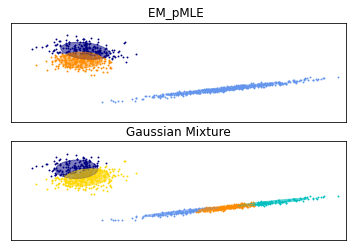

In [32]:


import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9.0, 5.0)
    plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), C),
    0.7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
]

k = 5
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=k, covariance_type="full").fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 1, "Gaussian Mixture")

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = EM_pMLE(k).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.Means,
    dpgmm.Covars,
    0,
    "EM_pMLE ",
)

plt.show()

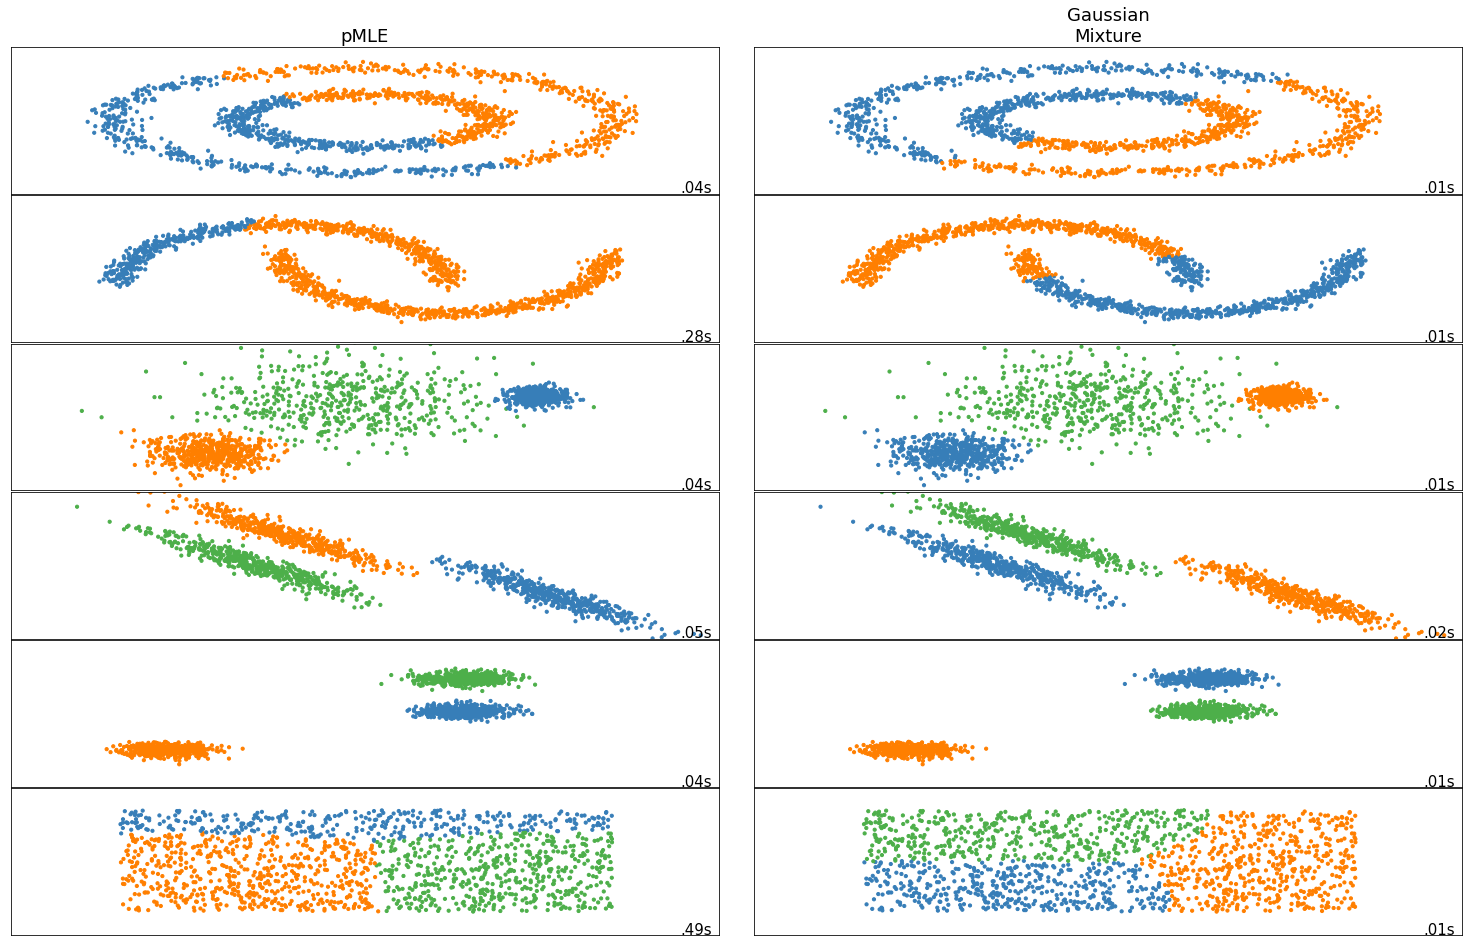

In [45]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    birch = cluster.Birch(n_clusters=params["n_clusters"])
    pMLE = EM_pMLE(params["n_clusters"])


    clustering_algorithms = (
        ("pMLE", pMLE),
        ("Gaussian\nMixture", gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

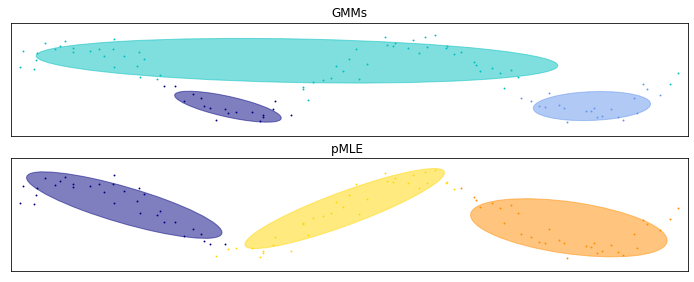

In [44]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4.0 * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.0
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3.0 * (np.sin(x) + np.random.normal(0, 0.2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(
    bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
)
k = 3
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(
    n_components=k, covariance_type="full", max_iter=100
).fit(X)
plot_results(
    X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "GMMs"
)

dpgmm = EM_pMLE(k).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.Means,
    dpgmm.Covars,
    1,
    "pMLE ")
plt.show()